# Soccer Pass

This notebook contains end to end performance evaluation of our validation dataset of 207 labelled images.

The Notebook is divided into 6 Parts:

0. Data Preparation
1. Player and Ball Detection
2. Player Team Identification
3. Perspective transform
4. Ball Possesion Identification
5. Reciever Identification

# 0. Data Preparation

We construct a dataframe from the COCO format JSON file, to track our objects and their respective attributes across different models and transformations.

In [ ]:
import os
import sys
import math
import json
import pandas as pd
from pandas import json_normalize
from tqdm import tqdm

In [2]:
MODE = 'eval' #eval or predict (inference)

In [3]:
#Prepare the labels in coco format
paths=['downloads/SoccerPass/SoccerPass-COCO/val.json']

dfs= []
for path in paths:
    # Load the COCO data from the JSON file
    with open(path) as f:
        coco_data = json.load(f)

    # Normalize the data into a DataFrame
    images_df = json_normalize(coco_data['images'])
    annotations_df = json_normalize(coco_data['annotations'])

    images_df=images_df.drop(columns=['license', 'flickr_url','coco_url', 'date_captured'])
    annotations_df=annotations_df.drop(columns=['segmentation', 'area','attributes.occluded','attributes.rotation','iscrowd'])
    annotations_df[['x', 'y', 'width', 'height']]=pd.DataFrame(annotations_df['bbox'].to_list())
    
    annotations_df['x'] = annotations_df['x'] + annotations_df['width']//2
    annotations_df['y'] = annotations_df['y'] + annotations_df['height']//2

    merged_df = pd.merge(annotations_df, images_df, right_on='id',left_on="image_id", how='left')

    merged_df['x'] = merged_df['x'] /merged_df['width_y']
    merged_df['width_x'] = merged_df['width_x'] /merged_df['width_y']
    merged_df['y'] = merged_df['y'] /merged_df['height_y']
    merged_df['height_x'] = merged_df['height_x'] /merged_df['height_y']


    merged_df['new_id'] = merged_df.groupby('image_id').cumcount() + 1
    merged_df=merged_df.drop(columns=['id_x', 'image_id', 'bbox', 'id_y', 'width_y', 'height_y'])

    new_columns = {'category_id': 'class',
                'attributes.Team': 'team',
                'attributes.Ball_Possesion': 'Ball_Possesion',
                'attributes.Ball_Reciever': 'Ball_Reciever',
                'width_x': 'w',
                'height_x': 'h',
                'file_name': 'image_name',
                'new_id': 'OID'}

    merged_df = merged_df.rename(columns=new_columns)
    merged_df.loc[merged_df['class']==1,'class']=0
    merged_df.loc[merged_df['class']==2,'class']=1
    # merged_df.to_csv("mer.csv",index=False)
    dfs.append(merged_df)

label_df=pd.concat(dfs)
display(label_df)


,class,Ball_Possesion,Ball_Reciever,team,x,y,w,h,image_name,OID
0,0,0,0,0,0.015625,0.318056,0.031250,0.105556,image_vics_1344.png,1
1,0,1,0,1,0.361719,0.486111,0.034375,0.116667,image_vics_1344.png,2
2,0,0,0,0,0.331250,0.461111,0.034375,0.123611,image_vics_1344.png,3
3,1,NaN,NaN,NaN,0.407031,0.490278,0.010156,0.019444,image_vics_1344.png,4
4,0,0,0,0,0.514062,0.237500,0.014844,0.075000,image_vics_1344.png,5
...,...,...,...,...,...,...,...,...,...,...
3306,0,0,0,0,0.327344,0.430556,0.022656,0.090278,image_vimp_678.png,11
3307,0,0,0,2,0.800000,0.409722,0.021875,0.109722,image_vimp_678.png,12
3308,0,0,0,0,0.885156,0.309722,0.017188,0.084722,image_vimp_678.png,13
3309,0,0,0,1,0.792969,0.331944,0.017969,0.088889,image_vimp_678.png,14


# 1. Player and Ball Detection


In [111]:
# Get all val image filenames
IMAGE_PATH = 'downloads/SoccerPass/SoccerPass-COCO/images/val'
IMAGE_FILENAMES = [os.path.join(IMAGE_PATH, f) for f in os.listdir(IMAGE_PATH)] #[:10] #ONLY 10 IMAGES FOR TESTING, REMOVE LATER
print("Number of images",len(IMAGE_FILENAMES))

Number of images 207


## 1.1 YOLOV8

We use YOLOV8 model finetuned on out training dataset to identify the bounding boxes of Players and the football.

In [5]:
# Object Detection 
import torch
from ultralytics import YOLO


# Build and load model (Yolov8l without pretraining, 1080 resolution)
Yolov8Detector = YOLO('runs/YOLOv8/yolov8l_soccerpass_fixed_res_1080_nopretrain/weights/best.pt')

device = 0 #0,1,2=cuda device 0,1,2 else 'cpu'

#Pass Data obtain Predictions
results = []
for i in range(len(IMAGE_FILENAMES)):
    r = Yolov8Detector.predict(source=IMAGE_FILENAMES[i], device=device)
    results += r
len(results)


image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_snjv_31.png: 640x1088 18 Players, 1 Football, 67.2ms
Speed: 7.0ms preprocess, 67.2ms inference, 4.0ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_vics_1386.png: 640x1088 13 Players, 1 Football, 62.4ms
Speed: 6.2ms preprocess, 62.4ms inference, 1.8ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_prmw_1298.png: 640x1088 17 Players, 1 Football, 54.9ms
Speed: 5.8ms preprocess, 54.9ms inference, 2.0ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_snjv_312.png: 640x1088 14 Players, 1 Football, 55.5ms
Speed: 6.1ms preprocess, 55.5ms inference, 1.8ms postprocess per image at shape (1

Speed: 6.1ms preprocess, 56.4ms inference, 1.8ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_prtl_1223.png: 640x1088 14 Players, 1 Football, 54.7ms
Speed: 6.1ms preprocess, 54.7ms inference, 1.8ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_snjv_389.png: 640x1088 17 Players, 1 Football, 55.4ms
Speed: 5.9ms preprocess, 55.4ms inference, 1.7ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_prmw_1244.png: 640x1088 12 Players, 1 Football, 56.2ms
Speed: 4.7ms preprocess, 56.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_viml_749.png: 640x1088 21 Players, 1


image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_prtl_1074.png: 640x1088 17 Players, 1 Football, 56.0ms
Speed: 5.6ms preprocess, 56.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_viml_747.png: 640x1088 16 Players, 1 Football, 56.0ms
Speed: 5.6ms preprocess, 56.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_prmw_1285.png: 640x1088 15 Players, 1 Football, 55.8ms
Speed: 5.7ms preprocess, 55.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_vics_1395.png: 640x1088 7 Players, 1 Football, 55.4ms
Speed: 5.5ms preprocess, 55.4ms inference, 1.7ms postprocess per image at shape (

Speed: 5.7ms preprocess, 63.7ms inference, 1.5ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_snjv_190.png: 640x1088 16 Players, 1 Football, 56.1ms
Speed: 5.6ms preprocess, 56.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_vimp_603.png: 640x1088 17 Players, 1 Football, 51.7ms
Speed: 5.9ms preprocess, 51.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_snjv_435.png: 640x1088 23 Players, 1 Football, 57.6ms
Speed: 5.6ms preprocess, 57.6ms inference, 1.4ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_vimp_571.png: 640x1088 14 Players, 1 F


image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_snjv_319.png: 640x1088 20 Players, 55.0ms
Speed: 5.6ms preprocess, 55.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_snjv_87.png: 640x1088 14 Players, 1 Football, 54.5ms
Speed: 5.5ms preprocess, 54.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_viml_724.png: 640x1088 17 Players, 1 Football, 56.5ms
Speed: 5.7ms preprocess, 56.5ms inference, 1.4ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_snjv_40.png: 640x1088 18 Players, 1 Football, 56.5ms
Speed: 5.7ms preprocess, 56.5ms inference, 1.7ms postprocess per image at shape (1, 3, 1088, 1088

Speed: 6.0ms preprocess, 56.4ms inference, 1.7ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_prmw_1238.png: 640x1088 18 Players, 1 Football, 54.9ms
Speed: 5.7ms preprocess, 54.9ms inference, 1.5ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_snjv_14.png: 640x1088 16 Players, 1 Football, 54.7ms
Speed: 5.6ms preprocess, 54.7ms inference, 1.5ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_snjv_368.png: 640x1088 10 Players, 1 Football, 55.0ms
Speed: 5.9ms preprocess, 55.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_prtl_1091.png: 640x1088 18 Players, 1 


image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_snjv_302.png: 640x1088 16 Players, 1 Football, 56.2ms
Speed: 6.2ms preprocess, 56.2ms inference, 1.9ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_snjv_271.png: 640x1088 22 Players, 1 Football, 56.7ms
Speed: 6.3ms preprocess, 56.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_prtl_1096.png: 640x1088 15 Players, 1 Football, 56.4ms
Speed: 6.4ms preprocess, 56.4ms inference, 1.9ms postprocess per image at shape (1, 3, 1088, 1088)

image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-COCO/images/val/image_snjv_456.png: 640x1088 20 Players, 1 Football, 56.5ms
Speed: 6.5ms preprocess, 56.5ms inference, 2.0ms postprocess per image at shape (1

207

In [6]:
# Create dataframe from object detection predictions
detect_df = [['class', 'x', 'y', 'w', 'h', 'image_name', 'OID']] #Headers

for res in results: #Iterate results of prediction
    max_ball_conf = 0.
    max_ball_conf_row = None
    for i, box in enumerate(res.boxes):
        oid = i+1
        coords = box.xywhn.detach().cpu()
        cls = box.cls.detach().cpu()
        cls = int(cls.data[0])
        conf = box.conf.detach().cpu()
        conf = float(conf.data[0])
        if cls == 1 and conf > max_ball_conf: #Get max conf ball out of all ball predictions for image
            max_ball_conf = conf
            max_ball_conf_row = [cls ,coords[0][0].item(), coords[0][1].item(), coords[0][2].item(), coords[0][3].item(), os.path.split(res.path)[1], oid]
        elif cls == 0: #For player, just directly add the prediction
            row = [cls ,coords[0][0].item(), coords[0][1].item(), coords[0][2].item(), coords[0][3].item(), os.path.split(res.path)[1], oid]
            detect_df.append(row)
    if max_ball_conf_row is not None:
        detect_df.append(max_ball_conf_row)
        
headers = detect_df.pop(0)
detect_df = pd.DataFrame(detect_df, columns=headers) #Convert to df
detect_df

,class,x,y,w,h,image_name,OID
0,0,0.205118,0.705206,0.049804,0.151780,image_snjv_31.png,1
1,0,0.812973,0.379201,0.027491,0.109707,image_snjv_31.png,2
2,0,0.561093,0.598562,0.047636,0.124644,image_snjv_31.png,3
3,0,0.744281,0.913392,0.049667,0.170521,image_snjv_31.png,4
4,0,0.563893,0.410553,0.023120,0.113618,image_snjv_31.png,5
...,...,...,...,...,...,...,...
3363,0,0.168206,0.409499,0.024705,0.087617,image_snjv_26.png,12
3364,0,0.567300,0.332049,0.014766,0.074426,image_snjv_26.png,13
3365,0,0.550931,0.416630,0.016643,0.090706,image_snjv_26.png,14
3366,0,0.166430,0.322427,0.020103,0.068800,image_snjv_26.png,15


## 1.2 Hungarian Matching

We use the hungarian algorithm with distance cost to match the predicted yolo outputs and the associated labels in the dataframe. The predictions are column wise appended as the pred_x, pred_y,pred_h,pred_w columns.

In [7]:
# Hungarian Matching between predicted boxes df and labels df. Will only be used for eval (inference doesnt need label)
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import euclidean_distances

pd.set_option('mode.chained_assignment', None)

# select the common image names between the two DataFrames
common_image_names = set(label_df['image_name']).intersection(set(detect_df['image_name']))

# loop through each common image name and perform the matching
for image_name in common_image_names:
    # select the relevant rows from each DataFrame based on the image name
    labels_image = label_df[label_df['image_name'] == image_name]
    pred_image = detect_df[detect_df['image_name'] == image_name]
    
    # calculate the centroids of the labels objects
    labels_image['x_center'] = labels_image['x']
    labels_image['y_center'] = labels_image['y']
    labels_centroids = labels_image.loc[:, ['x_center', 'y_center']].values
    
    # get the centroids of the predicted objects
    pred_centroids = pred_image.loc[:, ['x', 'y']].values
    
    # calculate the pairwise Euclidean distances between the centroids
    distances = euclidean_distances(labels_centroids, pred_centroids)
    
    # use the Hungarian algorithm to find the optimal assignment of labels to preds
    row_ind, col_ind = linear_sum_assignment(distances)
    
    # loop through each assignment and append the predicted class, x, y, w, and h to the labels_df
    for i, j in zip(row_ind, col_ind):
        label_index = labels_image.index[i]
        pred_index = pred_image.index[j]
        label_df.loc[label_index, 'pred_class'] = detect_df.loc[pred_index, 'class']
        label_df.loc[label_index, 'pred_x'] = detect_df.loc[pred_index, 'x']
        label_df.loc[label_index, 'pred_y'] = detect_df.loc[pred_index, 'y']
        label_df.loc[label_index, 'pred_w'] = detect_df.loc[pred_index, 'w']
        label_df.loc[label_index, 'pred_h'] = detect_df.loc[pred_index, 'h']
        
display(label_df)

,class,Ball_Possesion,Ball_Reciever,team,x,y,w,h,image_name,OID,pred_class,pred_x,pred_y,pred_w,pred_h
0,0,0,0,0,0.015625,0.318056,0.031250,0.105556,image_vics_1344.png,1,0.0,0.015327,0.318150,0.030654,0.105568
1,0,1,0,1,0.361719,0.486111,0.034375,0.116667,image_vics_1344.png,2,0.0,0.366168,0.484811,0.047190,0.118679
2,0,0,0,0,0.331250,0.461111,0.034375,0.123611,image_vics_1344.png,3,0.0,0.331753,0.462112,0.035968,0.124128
3,1,NaN,NaN,NaN,0.407031,0.490278,0.010156,0.019444,image_vics_1344.png,4,1.0,0.407853,0.490848,0.010881,0.020293
4,0,0,0,0,0.514062,0.237500,0.014844,0.075000,image_vics_1344.png,5,0.0,0.514831,0.238202,0.015551,0.073689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,0,0,0,0,0.327344,0.430556,0.022656,0.090278,image_vimp_678.png,11,0.0,0.327721,0.433267,0.021583,0.097270
3307,0,0,0,2,0.800000,0.409722,0.021875,0.109722,image_vimp_678.png,12,0.0,0.799344,0.411012,0.022984,0.109050
3308,0,0,0,0,0.885156,0.309722,0.017188,0.084722,image_vimp_678.png,13,0.0,0.885345,0.309862,0.017325,0.086714
3309,0,0,0,1,0.792969,0.331944,0.017969,0.088889,image_vimp_678.png,14,0.0,0.792633,0.332272,0.017939,0.091417


# 2. Team Identification

We cluster the crops of player images to obtain the team/group values

In [8]:
import numpy as np
from clustimage import Clustimage
from matplotlib import image
import matplotlib.pyplot as plt
from collections import Counter
import cv2

In [9]:
def calc_acc(pred_labels, true_labels):
#     print(pred_labels, true_labels)
    n = len(true_labels)
    count=0
    for ix in range(n):
        if((true_labels is None) or (pred_labels is None)) :
            continue
        elif (true_labels[ix]==pred_labels[ix]):
            count+=1
  
    return count/n

## 2.1 Pre-Processing crop

We crop the bounding box from the image and 
the cropped_image containing the player is then passed through Filter to smoothen the colours.

In [ ]:
def pre_process_crop(image, bbox):
    H = image.shape[0]
    W = image.shape[1]

    x = int(bbox[0]*W)
    y = int(bbox[1]*H)
    w = int(bbox[2]*W)
    h = int(bbox[3]*H)
    
    #Extracting Crop from given image with bbox specs
    crop = image[y:y+h, x:x+w]
    crop = cv2.resize(crop, (20,40))

    #Applying filters to the crop
    crop = cv2.medianBlur(crop,3)
    crop = cv2.bilateralFilter(crop,5,30,30)
    
    return crop

## 2.2 Matching Cluster to Labels

The cluster ids are then matched with the team labels using highest frequency
to assign the best matching team values to each cluster.

In [11]:
def formatPred(pred):
    y = np.unique(pred, return_counts=True)
    z = sorted(zip(y[1], y[0]), reverse=True)
    res = pred.copy()
    i=0
    
    for tup in z:
        idx_list = np.where(pred == tup[1])[0]

    # print(tup, idx_list)
        for idx in idx_list:
            res[idx] = i
        i+=1
    
    b = []
    for ele in res:
        if ele == 0:
            b.append(1)
        elif ele == 1:
            b.append(0)
        else:
            b.append(ele)
#     b =  np.array(b)   
#     print('res: {}, b:{}'.format(res,b))
    fin = [res, b]

    return fin

In [12]:
paths = [IMAGE_PATH]

## 2.3 Clustering

We flatten the cropped and filtered "player" image and pass all such "player" arrays to a Agglomerative clustering algorithm that utilises PCA.

In [13]:
def cluster(yolo_df):
    total_boxes = 0
    total_misclassified = 0

    groups = yolo_df.groupby("image_name")


  # loop through each group and apply the code snippet to each image
    for image_name, group in groups:
        image_path = None
        for path in paths:
            temp_path = os.path.join(path, image_name)
            if os.path.exists(temp_path):
                image_path = temp_path
                break

        if image_path is None:
            raise ValueError(f"Image file not found: {image_name}")

        img = image.imread(image_path)

        players_info = group[group['class'] == 0.0]
      
        true_labels = np.array(players_info['team'].tolist(), dtype=np.int32)
        num_cats = len(pd.unique(players_info['team'])) 

        player_boxes = []

        for index, row in players_info.iterrows():
            if(row['pred_class'] == 0.0):
                bbox = [row['pred_x']-(row['pred_w']/2), row['pred_y']-(row['pred_h']/2), row['pred_w'], row['pred_h']]
                crop = pre_process_crop(img, bbox)
                player_boxes.append(crop)  
            else:
                continue
                
        player_boxes_reshaped = np.array(player_boxes).reshape(len(player_boxes),-1)
        player_boxes_reshaped = player_boxes_reshaped/255.0

        cl = Clustimage(method='pca',
                    embedding='tsne',
                    grayscale=False,
                    dim=(20,40),
                    params_pca={'n_components':0.95},
                    verbose=60)

        results = cl.fit_transform(player_boxes_reshaped,
                                cluster='agglomerative',
                                evaluate='silhouette',
                                metric='euclidean',
                                linkage='ward',
                                min_clust=num_cats,
                                max_clust=num_cats,
                                cluster_space='high')

        pred_labels = list(results['labels'])
        pred_class_list = players_info['pred_class'].tolist()
        nan_idx = [i for i, elem in enumerate(pred_class_list) if math.isnan(elem)]
        
        res = formatPred(pred_labels)
        if (len(nan_idx) > 0):
            for idx in nan_idx:
                res[0].insert(idx, None)
                res[1].insert(idx, None)
                
        if (calc_acc(res[0], true_labels) > calc_acc(res[1], true_labels)):
            acc = calc_acc(res[0], true_labels)
            preds = res[0]
        else:
            acc = calc_acc(res[1], true_labels)
            preds = res[1]

        i = 0
        preds = [x for x in preds if x is not None]
        for index, row in players_info.iterrows():
            if((row['pred_class']) != 0.0):
                continue
            
            yolo_df.loc[index, 'pred_team'] = int(preds[i])
            i+=1
            
        print("name: {}, preds: {}, total boxes in : {}".format(image_name, preds, players_info.shape[0]))
        total_boxes += players_info.shape[0]

    print("total_boxes: {} ,  total_images: {}".format(total_boxes, len(groups)))

    return yolo_df

In [14]:
label_df = cluster(label_df)

[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 781.64it/s]
[clustimage] >DEBUG> [[1 2 1 3 2 1 2 2 2 2 1 1 2 2 3 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.2905]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 1 3 2 1 2 2 2 2 1 1 2 2 3 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1238.png, preds: [0, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 2, 0, 1, 0], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 776.58it/s]
[clustimage] >DEBUG> [[1 1 2 1 2 2 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.36197]
[clustimage] >DEBUG> sillclust: [          2]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 2 2 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prmw_1240.png, preds: [1, 1, 0, 1, 0, 0, 1, 1, 0, 1], total boxes in : 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 816.81it/s]
[clustimage] >DEBUG> [[1 3 3 3 2 3 1 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.24878]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 3 3 3 2 3 1 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1244.png, preds: [1, 0, 0, 0, 2, 0, 1, 1, 2, 1, 1], total boxes in : 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 802.43it/s]
[clustimage] >DEBUG> [[3 1 1 3 3 2 1 3 1 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.18712]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 1 1 3 3 2 1 3 1 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1245.png, preds: [1, 0, 0, 1, 1, 2, 0, 1, 0, 2, 0, 1], total boxes in : 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 763.85it/s]
[clustimage] >DEBUG> [[1 2 2 2 2 1 1 2 1 1 2 1 1 1 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.28303]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 2 1 1 2 1 1 2 1 1 1 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1257.png, preds: [1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 2], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 852.67it/s]
[clustimage] >DEBUG> [[2 1 3 1 1 1 2 2 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.32939]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 3 1 1 1 2 2 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1269.png, preds: [1, 0, 2, 0, 0, 0, 1, 1, 0, 2, 0], total boxes in : 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 829.90it/s]
[clustimage] >DEBUG> [[1 3 2 3 3 1 2 1 1 1 3 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.28593]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 3 2 3 3 1 2 1 1 1 3 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1273.png, preds: [0, 1, 2, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 2], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 802.58it/s]
[clustimage] >DEBUG> [[2 4 1 3 1 2 2 4 1 3 1 4 3 1 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.22857]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[2 4 1 3 1 2 2 4 1 3 1 4 3 1 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prmw_1278.png, preds: [3, 2, 0, 1, 0, 3, 3, 2, 0, 1, 0, 2, 1, 0, 0, 1, 0], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 524.94it/s]
[clustimage] >DEBUG> [[1 3 2 2 1 1 1 2 1 1 2 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.29249]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 3 2 2 1 1 1 2 1 1 2 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1285.png, preds: [1, 2, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 600.22it/s]
[clustimage] >DEBUG> [[3 2 1 1 2 1 2 1 2 2 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.34417]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 2 1 1 2 1 2 1 2 2 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1290.png, preds: [2, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 761.35it/s]
[clustimage] >DEBUG> [[3 1 3 1 1 3 2 1 2 3 2 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.25188]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 1 3 1 1 3 2 1 2 3 2 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1292.png, preds: [1, 0, 1, 0, 0, 1, 2, 0, 2, 1, 2, 2, 1, 0, 0], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 749.92it/s]
[clustimage] >DEBUG> [[1 1 2 2 2 2 2 1 1 2 1 1 2 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.3577]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 2 2 2 1 1 2 1 1 2 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1297.png, preds: [1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 2], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 816.49it/s]
[clustimage] >DEBUG> [[3 1 1 1 4 3 3 4 1 2 1 4 3 1 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.26238]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 4 3 3 4 1 2 1 4 3 1 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prmw_1298.png, preds: [1, 0, 0, 0, 2, 1, 1, 2, 0, 3, 0, 2, 1, 0, 1, 0, 1], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 798.61it/s]
[clustimage] >DEBUG> [[2 2 1 1 1 1 1 3 2 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.25757]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 1 1 1 3 2 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1300.png, preds: [0, 0, 1, 1, 1, 1, 1, 2, 0, 1, 0, 2], total boxes in : 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 697.42it/s]
[clustimage] >DEBUG> [[3 1 3 1 2 3 3 2 1 2 1 3 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.24069]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 1 3 1 2 3 3 2 1 2 1 3 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1303.png, preds: [1, 0, 1, 0, 2, 1, 1, 2, 0, 2, 0, 1, 0, 2, 0, 2], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 766.22it/s]
[clustimage] >DEBUG> [[1 1 1 3 1 3 2 2 1 2 2 1 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [      0.199]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 1 3 2 2 1 2 2 1 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1307.png, preds: [0, 0, 0, 2, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 2], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 614.73it/s]
[clustimage] >DEBUG> [[3 1 1 3 2 3 3 2 3 3 3 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.25124]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 1 1 3 2 3 3 2 3 3 3 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1323.png, preds: [1, 0, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 0], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 711.50it/s]
[clustimage] >DEBUG> [[1 2 1 3 1 1 2 2 1 2 2 2 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.2996]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 1 3 1 1 2 2 1 2 2 2 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1331.png, preds: [0, 1, 0, 2, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 758.60it/s]
[clustimage] >DEBUG> [[4 4 4 1 1 1 2 4 1 2 1 2 3 3 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.20003]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[4 4 4 1 1 1 2 4 1 2 1 2 3 3 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prmw_1338.png, preds: [1, 1, 1, 0, 0, 0, 2, 1, 0, 2, 0, 2, 3, 3, 1], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 646.27it/s]
[clustimage] >DEBUG> [[1 2 1 1 2 2 2 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.22158]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 2 2 2 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1340.png, preds: [0, 1, 0, 0, 1, 1, 1, 1, 1, 2], total boxes in : 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 692.59it/s]
[clustimage] >DEBUG> [[2 2 1 1 1 1 1 2 3 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.37396]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 1 1 1 2 3 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1027.png, preds: [0, 0, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0], total boxes in : 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 783.54it/s]
[clustimage] >DEBUG> [[2 2 1 1 1 2 3 1 1 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.31474]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 1 2 3 1 1 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1030.png, preds: [0, 0, 1, 1, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 779.32it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 2 2 1 1 1 3 4 1 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.31461]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 2 2 1 1 1 3 4 1 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1047.png, preds: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 3, 2, 1, 1, 1, 0, 0], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 615.63it/s]
[clustimage] >DEBUG> [[2 2 1 1 2 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.29799]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 2 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1052.png, preds: [1, 1, 0, 0, 1, 1, 2, 0, 0], total boxes in : 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 705.87it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 1 1 2 2 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.34854]
[clustimage] >DEBUG> sillclust: [          2]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 1 1 2 2 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1059.png, preds: [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 809.87it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 1 1 2 2 2 2 2 2 3 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.26953]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 1 1 2 2 2 2 2 2 3 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1074.png, preds: [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 543.59it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 1 2 2 2 2 2 2 2 2 1 1 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.27289]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 1 2 2 2 2 2 2 2 2 1 1 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1077.png, preds: [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1], total boxes in : 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 741.17it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 2 2 2 1 1 1 1 2 3 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.3382]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 2 2 2 1 1 1 1 2 3 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1091.png, preds: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 762.60it/s]
[clustimage] >DEBUG> [[1 3 1 2 2 1 1 1 3 3 3 1 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.22712]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 3 1 2 2 1 1 1 3 3 3 1 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1096.png, preds: [1, 0, 1, 2, 2, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 798.15it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 1 3 3 3 3 3 1 3 2 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.30863]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 1 3 3 3 3 3 1 3 2 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1099.png, preds: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 0, 2], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 786.33it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.27562]
[clustimage] >DEBUG> sillclust: [          2]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1104.png, preds: [1, 0, 1, 1, 1, 0, 0, 0, 0], total boxes in : 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1005.83it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 2 2 1 1 1 1 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.40716]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 2 2 1 1 1 1 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1108.png, preds: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 542.32it/s]
[clustimage] >DEBUG> [[2 2 2 2 1 1 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.31773]
[clustimage] >DEBUG> sillclust: [          2]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 1 1 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1110.png, preds: [0, 0, 0, 0, 1, 1, 0, 1, 1, 0], total boxes in : 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 859.84it/s]
[clustimage] >DEBUG> [[3 2 3 3 3 3 3 3 1 1 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.26642]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 2 3 3 3 3 3 3 1 1 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1118.png, preds: [1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 717.47it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 1 1 3 3 2 3 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.31986]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 1 1 3 3 2 3 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1121.png, preds: [1, 0, 0, 0, 1, 0, 0, 2, 2, 1, 2, 2, 1, 1], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 800.44it/s]
[clustimage] >DEBUG> [[1 2 2 2 2 3 2 2 2 2 1 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.32516]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 2 3 2 2 2 2 1 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1128.png, preds: [0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 807.37it/s]
[clustimage] >DEBUG> [[3 3 3 2 3 2 1 2 1 1 1 1 1 1 1 1 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.23476]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 3 3 2 3 2 1 2 1 1 1 1 1 1 1 1 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1141.png, preds: [0, 0, 0, 2, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2], total boxes in : 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 336.38it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 1 1 3 2 2 2 1 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.30517]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 1 1 3 2 2 2 1 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1144.png, preds: [1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 879.49it/s]
[clustimage] >DEBUG> [[1 1 2 1 1 3 1 1 1 2 2 2 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.20158]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 1 3 1 1 1 2 2 2 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1147.png, preds: [1, 1, 0, 1, 1, 2, 1, 1, 1, 0, 0, 0, 2, 0, 0], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 928.15it/s]
[clustimage] >DEBUG> [[3 2 2 2 2 2 1 1 1 1 1 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.26975]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 2 2 2 2 2 1 1 1 1 1 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1159.png, preds: [2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 518.39it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 1 2 3 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.27083]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 1 2 3 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1162.png, preds: [1, 0, 1, 1, 1, 1, 0, 2, 0, 0, 0], total boxes in : 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 849.74it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 2 3 2 1 2 2 2 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.34423]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 2 3 2 1 2 2 2 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1164.png, preds: [0, 0, 0, 0, 0, 1, 1, 2, 1, 0, 1, 1, 1, 0, 1, 1], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 759.84it/s]
[clustimage] >DEBUG> [[1 1 1 1 2 1 1 2 3 2 2 2 3 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.21078]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 2 1 1 2 3 2 2 2 3 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1166.png, preds: [0, 0, 0, 0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 1, 1], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 856.33it/s]
[clustimage] >DEBUG> [[2 1 2 2 1 1 2 3 2 1 2 2 1 1 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.4879]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 2 2 1 1 2 3 2 1 2 2 1 1 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1182.png, preds: [1, 0, 1, 1, 0, 0, 1, 2, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 643.10it/s]
[clustimage] >DEBUG> [[1 2 2 2 1 1 1 3 1 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.28851]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 1 1 1 3 1 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1186.png, preds: [0, 1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 1], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 825.33it/s]
[clustimage] >DEBUG> [[3 2 2 1 2 2 1 2 3 1 2 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.28847]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 2 2 1 2 2 1 2 3 1 2 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1187.png, preds: [2, 1, 1, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 1], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 651.39it/s]
[clustimage] >DEBUG> [[2 2 2 2 1 1 2 1 2 1 3 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.37239]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 1 1 2 1 2 1 3 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1197.png, preds: [1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 2, 0, 1, 0], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 786.04it/s]
[clustimage] >DEBUG> [[3 4 3 3 3 1 1 1 3 1 1 1 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.33681]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[3 4 3 3 3 1 1 1 3 1 1 1 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1200.png, preds: [1, 2, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 3], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 606.38it/s]
[clustimage] >DEBUG> [[1 2 2 1 1 1 1 2 2 1 2 1 1 1 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.19745]
[clustimage] >DEBUG> sillclust: [          2]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 1 1 1 2 2 1 2 1 1 1 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1201.png, preds: [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 821.29it/s]
[clustimage] >DEBUG> [[2 1 3 1 2 2 3 2 1 3 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.25464]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 3 1 2 2 3 2 1 3 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1208.png, preds: [1, 2, 0, 2, 1, 1, 0, 1, 2, 0, 0, 1, 2], total boxes in : 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 777.59it/s]
[clustimage] >DEBUG> [[2 2 2 2 1 1 2 1 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.33854]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 1 1 2 1 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1217.png, preds: [1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 2], total boxes in : 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 49.22it/s]
[clustimage] >DEBUG> [[1 2 2 2 2 1 2 2 3 2 1 2 1 1 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.32463]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 2 1 2 2 3 2 1 2 1 1 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1218.png, preds: [0, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 0, 1, 0, 0, 0], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 765.10it/s]
[clustimage] >DEBUG> [[2 3 2 4 1 2 2 2 2 1 1 2 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.21312]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[2 3 2 4 1 2 2 2 2 1 1 2 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1221.png, preds: [0, 3, 0, 2, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 869.29it/s]
[clustimage] >DEBUG> [[3 2 2 2 1 1 1 2 2 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.20914]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 2 2 2 1 1 1 2 2 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1223.png, preds: [2, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0], total boxes in : 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 793.17it/s]
[clustimage] >DEBUG> [[2 2 1 1 2 2 1 1 1 3 2 1 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.3386]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 2 2 1 1 1 3 2 1 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1225.png, preds: [1, 1, 0, 0, 1, 1, 0, 0, 0, 2, 1, 0, 1, 1, 0, 0], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 914.79it/s]
[clustimage] >DEBUG> [[2 1 2 1 2 2 1 1 1 3 2 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.2445]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 2 2 1 1 1 3 2 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1227.png, preds: [1, 0, 1, 0, 1, 1, 0, 0, 0, 2, 1, 1, 1, 0, 0], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 617.72it/s]
[clustimage] >DEBUG> [[3 3 3 4 2 2 1 1 2 2 1 1 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.25091]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[3 3 3 4 2 2 1 1 2 2 1 1 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1229.png, preds: [1, 1, 1, 3, 2, 2, 0, 0, 2, 2, 0, 0, 1, 0, 0], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 788.70it/s]
[clustimage] >DEBUG> [[1 1 2 1 2 2 1 1 2 1 2 3 2 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.32651]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 2 2 1 1 2 1 2 3 2 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_109.png, preds: [0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 2, 1, 1, 0, 1], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 748.05it/s]
[clustimage] >DEBUG> [[3 2 1 1 3 3 3 1 3 1 3 1 3 1 1 1 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.30458]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 2 1 1 3 3 3 1 3 1 3 1 3 1 1 1 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_110.png, preds: [1, 2, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 2, 0], total boxes in : 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 759.56it/s]
[clustimage] >DEBUG> [[1 3 3 2 1 2 1 2 1 2 1 2 1 1 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.33967]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 3 3 2 1 2 1 2 1 2 1 2 1 1 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_119.png, preds: [0, 2, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 2, 2], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 590.83it/s]
[clustimage] >DEBUG> [[3 3 1 1 3 1 3 2 4 1 1 4 1 3 1 4 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.30549]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[3 3 1 1 3 1 3 2 4 1 1 4 1 3 1 4 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_122.png, preds: [1, 1, 0, 0, 1, 0, 1, 3, 2, 0, 0, 2, 0, 1, 0, 2, 1, 0, 0], total boxes in : 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 750.19it/s]
[clustimage] >DEBUG> [[2 1 2 1 2 2 2 3 2 2 1 2 1 2 1 2 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.34374]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 2 2 2 3 2 2 1 2 1 2 1 2 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_127.png, preds: [1, 0, 1, 0, 1, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0], total boxes in : 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 585.96it/s]
[clustimage] >DEBUG> [[2 2 1 1 1 3 2 1 1 1 2 2 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.31768]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 1 3 2 1 1 1 2 2 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_14.png, preds: [1, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 801.05it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 2 3 2 1 2 2 2 1 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.39716]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 2 3 2 1 2 2 2 1 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_153.png, preds: [1, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 1, 2, 2, 2], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 839.20it/s]
[clustimage] >DEBUG> [[1 2 1 1 3 1 2 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.32392]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 3 1 2 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_158.png, preds: [1, 0, 1, 1, 2, 1, 0, 0, 1, 0], total boxes in : 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 656.49it/s]
[clustimage] >DEBUG> [[2 2 2 2 1 1 3 3 1 1 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.23674]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 1 1 3 3 1 1 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_166.png, preds: [2, 2, 2, 2, 1, 1, 0, 0, 1, 1, 0, 0, 1], total boxes in : 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 631.58it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 1 3 3 1 2 3 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.24017]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 1 3 3 1 2 3 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_168.png, preds: [1, 2, 1, 1, 1, 1, 0, 0, 1, 2, 0, 1, 0, 0], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 788.70it/s]
[clustimage] >DEBUG> [[1 3 2 3 2 1 3 2 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.26908]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 3 2 3 2 1 3 2 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_170.png, preds: [0, 1, 2, 1, 2, 0, 1, 2, 0, 0, 0, 0], total boxes in : 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 745.79it/s]
[clustimage] >DEBUG> [[1 1 1 3 1 1 3 1 3 2 1 2 1 2 3 1 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.29315]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 1 1 3 1 3 2 1 2 1 2 3 1 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_184.png, preds: [1, 1, 1, 0, 1, 1, 0, 1, 0, 2, 1, 2, 1, 2, 0, 1, 0, 1, 0], total boxes in : 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 796.49it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 3 3 1 1 1 1 2 1 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.24276]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 3 3 1 1 1 1 2 1 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_190.png, preds: [0, 1, 0, 1, 1, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 845.97it/s]
[clustimage] >DEBUG> [[1 4 2 1 1 3 3 1 1 1 4 3 1 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.27898]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[1 4 2 1 1 3 3 1 1 1 4 3 1 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_197.png, preds: [1, 2, 3, 1, 1, 0, 0, 1, 1, 1, 2, 0, 1, 3, 1, 0], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 779.61it/s]
[clustimage] >DEBUG> [[2 1 1 1 1 2 3 2 2 2 2 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.31968]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 1 2 3 2 2 2 2 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_202.png, preds: [1, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 0, 0, 0], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 824.51it/s]
[clustimage] >DEBUG> [[3 2 1 3 3 2 3 3 1 1 3 1 1 1 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.22205]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 2 1 3 3 2 3 3 1 1 3 1 1 1 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_206.png, preds: [1, 2, 0, 1, 1, 2, 1, 1, 0, 0, 1, 0, 0, 0, 2, 2, 1], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 895.26it/s]
[clustimage] >DEBUG> [[2 3 2 3 2 1 1 1 1 1 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.2803]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 3 2 3 2 1 1 1 1 1 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_210.png, preds: [2, 0, 2, 0, 2, 1, 1, 1, 1, 1, 1, 0, 1], total boxes in : 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 881.34it/s]
[clustimage] >DEBUG> [[1 1 1 3 3 3 3 3 1 1 2 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.23445]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 3 3 3 3 1 1 2 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_211.png, preds: [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 0], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 841.05it/s]
[clustimage] >DEBUG> [[3 3 2 1 3 1 1 1 2 1 1 2 1 1 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.31977]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 3 2 1 3 1 1 1 2 1 1 2 1 1 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_220.png, preds: [0, 0, 2, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 2, 0], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 819.52it/s]
[clustimage] >DEBUG> [[2 2 1 1 1 1 1 3 3 2 3 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.32575]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 1 1 1 3 3 2 3 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_224.png, preds: [2, 2, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 809.87it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 1 1 2 2 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.38625]
[clustimage] >DEBUG> sillclust: [          2]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 1 1 2 2 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_229.png, preds: [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 838.69it/s]
[clustimage] >DEBUG> [[2 2 3 2 4 2 1 1 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.24647]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[2 2 3 2 4 2 1 1 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_23.png, preds: [1, 1, 3, 1, 2, 1, 0, 0, 0, 1, 0, 0], total boxes in : 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 725.66it/s]
[clustimage] >DEBUG> [[3 3 4 2 1 4 2 2 4 4 4 3 1 4 2 4 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.26402]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[3 3 4 2 1 4 2 2 4 4 4 3 1 4 2 4 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_25.png, preds: [2, 2, 1, 0, 3, 1, 0, 0, 1, 1, 1, 2, 3, 1, 0, 1, 0], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 853.19it/s]
[clustimage] >DEBUG> [[2 2 2 2 1 1 1 1 1 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.35421]
[clustimage] >DEBUG> sillclust: [          2]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 1 1 1 1 1 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_258.png, preds: [1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1], total boxes in : 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 826.14it/s]
[clustimage] >DEBUG> [[1 1 2 1 1 1 3 3 2 1 1 1 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.35052]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 1 1 3 3 2 1 1 1 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_26.png, preds: [1, 1, 0, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 0, 0, 0], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 807.84it/s]
[clustimage] >DEBUG> [[2 3 3 3 2 3 3 3 3 1 1 1 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.29111]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 3 3 3 2 3 3 3 3 1 1 1 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_265.png, preds: [2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 681.78it/s]
[clustimage] >DEBUG> [[2 3 3 3 3 3 1 1 1 1 1 1 2 1 1 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.35299]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 3 3 3 3 3 1 1 1 1 1 1 2 1 1 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_267.png, preds: [2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2, 2], total boxes in : 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 761.35it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 4 3 3 5 5 4 4 5 5 5 2 4 4 1 4 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.25414]
[clustimage] >DEBUG> sillclust: [          5]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 4 3 3 5 5 4 4 5 5 5 2 4 4 1 4 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_snjv_270.png, preds: [0, 0, 0, 0, 0, 1, 3, 3, 2, 2, 1, 1, 2, 2, 2, 4, 1, 1, 0, 1, 0], total boxes in : 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 831.21it/s]
[clustimage] >DEBUG> [[1 1 2 1 1 1 4 1 5 4 5 5 5 4 1 5 4 4 3 4 5]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.25068]
[clustimage] >DEBUG> sillclust: [          5]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 1 1 4 1 5 4 5 5 5 4 1 5 4 4 3 4 5]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_snjv_271.png, preds: [0, 0, 4, 0, 0, 0, 2, 0, 1, 2, 1, 1, 1, 2, 0, 1, 2, 2, 3, 2, 1], total boxes in : 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 798.76it/s]
[clustimage] >DEBUG> [[3 1 2 1 1 1 3 2 3 3 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.4062]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 1 2 1 1 1 3 2 3 3 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_287.png, preds: [1, 0, 2, 0, 0, 0, 1, 2, 1, 1, 0, 0, 1], total boxes in : 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 808.46it/s]
[clustimage] >DEBUG> [[3 1 4 1 3 3 1 1 4 5 5 1 4 1 2 1 5 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.26748]
[clustimage] >DEBUG> sillclust: [          5]
[clustimage] >DEBUG> clustlabx: [[3 1 4 1 3 3 1 1 4 5 5 1 4 1 2 1 5 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_snjv_296.png, preds: [1, 0, 3, 0, 1, 1, 0, 0, 3, 2, 2, 0, 3, 0, 4, 0, 2, 1], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 850.43it/s]
[clustimage] >DEBUG> [[2 2 1 4 1 1 1 2 4 4 1 1 1 2 1 3 3 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.27349]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[2 2 1 4 1 1 1 2 4 4 1 1 1 2 1 3 3 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_297.png, preds: [2, 2, 0, 1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 0, 3, 3, 1], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 807.53it/s]
[clustimage] >DEBUG> [[2 2 3 1 1 2 1 1 1 2 2 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.29456]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 3 1 1 2 1 1 1 2 2 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_299.png, preds: [1, 1, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 882.08it/s]
[clustimage] >DEBUG> [[2 1 2 1 1 2 2 1 1 1 1 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.35983]
[clustimage] >DEBUG> sillclust: [          2]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 1 2 2 1 1 1 1 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_301.png, preds: [1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 828.26it/s]
[clustimage] >DEBUG> [[2 2 3 2 2 1 1 1 2 1 1 1 1 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.36222]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 3 2 2 1 1 1 2 1 1 1 1 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_302.png, preds: [1, 1, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 840.37it/s]
[clustimage] >DEBUG> [[1 1 2 3 2 1 3 1 3 3 2 2 3 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.25824]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 2 3 2 1 3 1 3 3 2 2 3 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_303.png, preds: [0, 0, 2, 1, 2, 0, 1, 0, 1, 1, 2, 2, 1, 2, 0, 0, 0], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 848.19it/s]
[clustimage] >DEBUG> [[2 2 2 1 2 1 2 1 1 1 1 2 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.38078]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 2 1 2 1 1 1 1 2 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_304.png, preds: [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 1], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 933.52it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.48012]
[clustimage] >DEBUG> sillclust: [          2]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_305.png, preds: [1, 0, 1, 0, 0, 1, 1, 1], total boxes in : 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 853.54it/s]
[clustimage] >DEBUG> [[1 2 2 2 1 2 1 1 2 3 2 2 1 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.45345]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 1 2 1 1 2 3 2 2 1 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_31.png, preds: [0, 1, 1, 1, 0, 1, 0, 0, 1, 2, 1, 1, 0, 1, 0, 1, 0], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 880.97it/s]
[clustimage] >DEBUG> [[4 2 1 3 1 1 3 3 2 1 1 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.28315]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[4 2 1 3 1 1 3 3 2 1 1 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_312.png, preds: [3, 2, 0, 1, 0, 0, 1, 1, 2, 0, 0, 1, 2, 1], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 692.93it/s]
[clustimage] >DEBUG> [[3 2 1 1 2 1 1 1 1 3 1 1 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.31352]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 2 1 1 2 1 1 1 1 3 1 1 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_314.png, preds: [0, 2, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 871.63it/s]
[clustimage] >DEBUG> [[1 3 2 2 1 1 1 1 3 1 3 1 3 1 3 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.27984]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 3 2 2 1 1 1 1 3 1 3 1 3 1 3 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_315.png, preds: [0, 1, 2, 2, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 725.16it/s]
[clustimage] >DEBUG> [[1 2 2 1 3 3 3 2 2 2 1 1 1 3 1 3 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.28594]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 3 3 3 2 2 2 1 1 1 3 1 3 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_319.png, preds: [0, 1, 1, 0, 2, 2, 2, 1, 1, 1, 0, 0, 0, 2, 0, 2, 0, 1, 0], total boxes in : 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 847.85it/s]
[clustimage] >DEBUG> [[1 2 2 1 1 1 2 2 1 2 2 2 1 1 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.33001]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 1 1 2 2 1 2 2 2 1 1 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_322.png, preds: [0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 2, 1, 0], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 690.53it/s]
[clustimage] >DEBUG> [[2 1 3 2 1 1 2 2 1 1 2 2 1 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.39462]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 3 2 1 1 2 2 1 1 2 2 1 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_334.png, preds: [1, 0, 2, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 648.27it/s]
[clustimage] >DEBUG> [[2 1 2 1 2 1 2 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.4868]
[clustimage] >DEBUG> sillclust: [          2]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 2 1 2 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_335.png, preds: [0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1], total boxes in : 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 714.17it/s]
[clustimage] >DEBUG> [[2 3 1 1 2 2 3 1 1 1 1 1 3 3 3 1 3 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.2824]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 3 1 1 2 2 3 1 1 1 1 1 3 3 3 1 3 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_346.png, preds: [2, 1, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0], total boxes in : 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 766.08it/s]
[clustimage] >DEBUG> [[1 1 3 2 1 3 1 1 3 2 3 3 1 3 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.31555]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 3 2 1 3 1 1 3 2 3 3 1 3 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_354.png, preds: [0, 0, 1, 2, 0, 1, 0, 0, 1, 2, 1, 1, 0, 1, 1, 0, 0], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 779.32it/s]
[clustimage] >DEBUG> [[3 1 1 3 1 1 1 2 1 1 1 2 3 3 3 3 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.34631]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 1 1 3 1 1 1 2 1 1 1 2 3 3 3 3 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_355.png, preds: [0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1], total boxes in : 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 790.63it/s]
[clustimage] >DEBUG> [[1 1 1 3 2 3 1 1 1 2 1 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.42712]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 2 3 1 1 1 2 1 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_356.png, preds: [0, 0, 0, 1, 2, 1, 0, 0, 0, 2, 0, 1, 1, 2], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 745.12it/s]
[clustimage] >DEBUG> [[4 2 3 1 3 4 1 3 4 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.36807]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[4 2 3 1 3 4 1 3 4 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_368.png, preds: [1, 3, 0, 2, 0, 1, 2, 0, 1, 0], total boxes in : 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 582.79it/s]
[clustimage] >DEBUG> [[3 2 1 1 1 1 2 1 2 1 1 2 2 2 2 1 2 3 2 4 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.37265]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[3 2 1 1 1 1 2 1 2 1 1 2 2 2 2 1 2 3 2 4 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_37.png, preds: [2, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 1, 3, 2], total boxes in : 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 645.48it/s]
[clustimage] >DEBUG> [[1 3 1 2 3 3 1 1 3 3 1 1 1 3 1 1 4 3 3 3 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.38224]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[1 3 1 2 3 3 1 1 3 3 1 1 1 3 1 1 4 3 3 3 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_374.png, preds: [1, 0, 1, 2, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 3, 0, 0, 0, 2, 1, 0], total boxes in : 23
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 794.53it/s]
[clustimage] >DEBUG> [[1 1 3 3 3 3 2 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.33006]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 3 3 3 3 2 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_382.png, preds: [0, 0, 1, 1, 1, 1, 2, 0, 0, 0, 0, 2], total boxes in : 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 670.23it/s]
[clustimage] >DEBUG> [[1 1 2 2 1 1 1 1 1 2 2 2 2 1 3 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.42425]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 1 1 1 1 1 2 2 2 2 1 3 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_383.png, preds: [1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 2, 0, 1, 0], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 767.20it/s]
[clustimage] >DEBUG> [[3 1 3 3 2 3 1 1 3 1 1 3 4 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.3247]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[3 1 3 3 2 3 1 1 3 1 1 3 4 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_389.png, preds: [1, 0, 1, 1, 2, 1, 0, 0, 1, 0, 0, 1, 3, 0, 0, 2, 2], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 829.90it/s]
[clustimage] >DEBUG> [[3 2 2 2 1 1 1 1 1 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.35769]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 2 2 2 1 1 1 1 1 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_399.png, preds: [2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1], total boxes in : 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 793.77it/s]
[clustimage] >DEBUG> [[3 1 1 2 2 2 2 2 2 1 1 2 4 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.3717]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[3 1 1 2 2 2 2 2 2 1 1 2 4 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_40.png, preds: [3, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 0, 1, 0, 0], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 805.98it/s]
[clustimage] >DEBUG> [[2 1 2 1 3 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.38847]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 3 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_406.png, preds: [0, 1, 0, 1, 2, 0, 1, 1, 1], total boxes in : 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 780.92it/s]
[clustimage] >DEBUG> [[1 2 4 1 2 1 4 1 1 2 3 3 2 2 1 2 4 2 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.2684]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[1 2 4 1 2 1 4 1 1 2 3 3 2 2 1 2 4 2 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_41.png, preds: [0, 1, 2, 0, 1, 0, 2, 0, 0, 1, 3, 3, 1, 1, 0, 1, 2, 1, 1, 0, 3], total boxes in : 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 787.81it/s]
[clustimage] >DEBUG> [[3 4 3 3 3 4 3 3 4 4 4 1 3 4 4 4 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.18886]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[3 4 3 3 3 4 3 3 4 4 4 1 3 4 4 4 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_426.png, preds: [1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 810.02it/s]
[clustimage] >DEBUG> [[3 1 1 1 3 1 1 3 1 2 1 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.15239]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 3 1 1 3 1 2 1 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_431.png, preds: [1, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 1, 2], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 808.31it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 2 1 2 2 3 2 2 3 1 1 1 2 2 3 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.38786]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 2 1 2 2 3 2 2 3 1 1 1 2 2 3 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_435.png, preds: [1, 0, 1, 1, 1, 0, 1, 0, 0, 2, 0, 0, 2, 1, 1, 1, 0, 0, 2, 1, 1, 0], total boxes in : 22
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 640.45it/s]
[clustimage] >DEBUG> [[1 1 2 3 1 3 1 1 1 3 3 3 1 2 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.26127]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 2 3 1 3 1 1 1 3 3 3 1 2 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_441.png, preds: [1, 1, 2, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 2, 2, 2, 0], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 831.87it/s]
[clustimage] >DEBUG> [[2 2 1 1 1 2 1 3 2 1 1 1 1 1 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.27675]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 1 2 1 3 2 1 1 1 1 1 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_443.png, preds: [1, 1, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 790.48it/s]
[clustimage] >DEBUG> [[2 2 1 2 1 2 3 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.26791]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 1 2 1 2 3 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_447.png, preds: [0, 0, 1, 0, 1, 0, 2, 0, 0, 1], total boxes in : 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 905.31it/s]
[clustimage] >DEBUG> [[3 1 3 3 1 1 3 3 1 1 2 2 1 2 1 3 3 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.2292]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 1 3 3 1 1 3 3 1 1 2 2 1 2 1 3 3 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_456.png, preds: [0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 1, 0, 0, 1, 0, 1], total boxes in : 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 847.68it/s]
[clustimage] >DEBUG> [[1 2 2 1 1 1 2 2 1 2 1 2 3 1 3 1 1 2 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.30424]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 1 1 2 2 1 2 1 2 3 1 3 1 1 2 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_462.png, preds: [0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 2, 0, 2, 0, 0, 1, 1, 0, 1], total boxes in : 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 695.69it/s]
[clustimage] >DEBUG> [[2 1 1 2 1 2 2 1 1 2 1 1 2 1 3 3 1 1 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.31068]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 1 2 2 1 1 2 1 1 2 1 3 3 1 1 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_471.png, preds: [1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 2, 2, 0, 0, 1, 0, 2], total boxes in : 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [16] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 826.30it/s]
[clustimage] >DEBUG> [[5 5 1 1 4 1 1 1 4 4 4 3 3 1 1 1 5 1 4 4 5 4 2 4 5 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.21756]
[clustimage] >DEBUG> sillclust: [          5]
[clustimage] >DEBUG> clustlabx: [[5 5 1 1 4 1 1 1 4 4 4 3 3 1 1 1 5 1 4 4 5 4 2 4 5 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_snjv_477.png, preds: [2, 2, 0, 0, 1, 0, 0, 0, 1, 1, 1, 3, 3, 0, 0, 0, 2, 0, 1, 1, 2, 1, 4, 1, 2, 3], total boxes in : 26
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 911.01it/s]
[clustimage] >DEBUG> [[2 3 1 2 2 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.19813]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 3 1 2 2 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_482.png, preds: [0, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1], total boxes in : 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 929.18it/s]
[clustimage] >DEBUG> [[1 3 3 2 3 3 2 3 3 1 1 2 1 3 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.24649]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 3 3 2 3 3 2 3 3 1 1 2 1 3 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_483.png, preds: [0, 1, 1, 2, 1, 1, 2, 1, 1, 0, 0, 2, 0, 1, 0, 0, 2, 0], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 803.81it/s]
[clustimage] >DEBUG> [[3 1 1 2 3 1 1 1 3 3 1 3 1 1 2 3 1 3 3 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.48334]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 1 1 2 3 1 1 1 3 3 1 3 1 1 2 3 1 3 3 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_485.png, preds: [1, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 2, 1, 0, 1, 1, 0, 1, 2], total boxes in : 22
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 615.18it/s]
[clustimage] >DEBUG> [[1 1 1 2 2 1 2 3 2 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.28295]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 2 1 2 3 2 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_495.png, preds: [0, 0, 0, 1, 1, 0, 1, 2, 1, 1, 1, 2], total boxes in : 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 845.11it/s]
[clustimage] >DEBUG> [[1 1 1 1 2 2 2 2 1 1 1 2 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.41988]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 2 2 2 2 1 1 1 2 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_59.png, preds: [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 2], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 818.56it/s]
[clustimage] >DEBUG> [[1 3 1 4 3 3 2 1 4 5 2 1 1 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.3017]
[clustimage] >DEBUG> sillclust: [          5]
[clustimage] >DEBUG> clustlabx: [[1 3 1 4 3 3 2 1 4 5 2 1 1 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_snjv_71.png, preds: [0, 1, 0, 2, 1, 1, 3, 0, 2, 4, 3, 0, 0, 1, 1, 0], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 809.87it/s]
[clustimage] >DEBUG> [[4 1 4 2 4 4 1 3 4 4 4 1 4 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.31418]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[4 1 4 2 4 4 1 3 4 4 4 1 4 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_76.png, preds: [0, 1, 0, 3, 0, 0, 1, 2, 0, 0, 0, 1, 0, 2, 1, 1], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 718.94it/s]
[clustimage] >DEBUG> [[1 2 1 1 2 3 1 2 1 1 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.3684]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 2 3 1 2 1 1 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_78.png, preds: [1, 0, 1, 1, 0, 2, 1, 0, 1, 1, 0, 0, 0, 1], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 771.30it/s]
[clustimage] >DEBUG> [[2 1 1 2 2 2 1 2 2 3 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.35396]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 2 2 1 2 2 3 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_87.png, preds: [0, 1, 1, 0, 0, 0, 1, 0, 0, 2, 1, 1, 1, 1], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 792.13it/s]
[clustimage] >DEBUG> [[2 1 3 2 1 3 1 3 1 3 1 3 3 3 1 4 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.34077]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[2 1 3 2 1 3 1 3 1 3 1 3 3 3 1 4 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_91.png, preds: [2, 1, 0, 2, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 3, 1], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 744.60it/s]
[clustimage] >DEBUG> [[2 1 3 3 3 2 3 3 1 1 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.29299]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 3 3 3 2 3 3 1 1 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1344.png, preds: [2, 1, 0, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 621.01it/s]
[clustimage] >DEBUG> [[2 1 1 3 3 2 3 1 2 3 1 1 1 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.2825]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 1 3 3 2 3 1 2 3 1 1 1 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1367.png, preds: [1, 0, 0, 2, 2, 1, 2, 0, 1, 2, 0, 0, 0, 0, 1, 0, 1], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 791.98it/s]
[clustimage] >DEBUG> [[1 1 1 1 2 2 2 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.29452]
[clustimage] >DEBUG> sillclust: [          2]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 2 2 2 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_vics_1373.png, preds: [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0], total boxes in : 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 606.73it/s]
[clustimage] >DEBUG> [[1 1 1 2 2 2 1 3 2 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.31252]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 2 2 1 3 2 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1380.png, preds: [0, 0, 0, 1, 1, 1, 0, 2, 1, 0, 1, 1, 1], total boxes in : 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 859.14it/s]
[clustimage] >DEBUG> [[1 2 2 2 1 3 2 1 2 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.23649]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 1 3 2 1 2 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1381.png, preds: [0, 1, 1, 1, 0, 2, 1, 0, 1, 1, 0, 0, 1], total boxes in : 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 832.53it/s]
[clustimage] >DEBUG> [[1 2 2 1 2 1 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.37469]
[clustimage] >DEBUG> sillclust: [          2]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 2 1 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_vics_1383.png, preds: [1, 0, 0, 1, 0, 1, 1, 0, 1, 0], total boxes in : 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1009.46it/s]
[clustimage] >DEBUG> [[3 2 1 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.35363]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 2 1 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1384.png, preds: [2, 1, 0, 0, 0, 1, 0], total boxes in : 7
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 810.81it/s]
[clustimage] >DEBUG> [[2 1 2 1 2 1 1 3 3 3 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.26631]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 2 1 1 3 3 3 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1386.png, preds: [1, 0, 1, 0, 1, 0, 0, 2, 2, 2, 1, 0, 0], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 645.58it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 2 1 1 1 2 1 3 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.24647]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 2 1 1 1 2 1 3 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1388.png, preds: [1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 2, 0, 1, 1], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 632.72it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.22072]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1395.png, preds: [1, 0, 0, 0, 1, 0, 2], total boxes in : 7
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 952.82it/s]
[clustimage] >DEBUG> [[2 1 2 2 1 1 2 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.31577]
[clustimage] >DEBUG> sillclust: [          2]
[clustimage] >DEBUG> clustlabx: [[2 1 2 2 1 1 2 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_vics_1399.png, preds: [1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1], total boxes in : 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 678.14it/s]
[clustimage] >DEBUG> [[1 2 1 3 3 2 2 1 2 2 1 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.27394]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 1 3 3 2 2 1 2 2 1 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1402.png, preds: [0, 1, 0, 2, 2, 1, 1, 0, 1, 1, 0, 1, 2, 0, 0], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 902.58it/s]
[clustimage] >DEBUG> [[4 3 4 4 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.17373]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[4 3 4 4 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vics_1403.png, preds: [0, 1, 0, 0, 3, 2, 1], total boxes in : 7
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 975.42it/s]
[clustimage] >DEBUG> [[2 2 1 1 1 1 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.3559]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 1 1 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1409.png, preds: [1, 1, 0, 0, 0, 0, 1, 2, 0, 0], total boxes in : 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 859.84it/s]
[clustimage] >DEBUG> [[2 3 1 1 1 1 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.29515]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 3 1 1 1 1 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1411.png, preds: [1, 2, 0, 0, 0, 0, 1, 0, 0, 1], total boxes in : 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 851.46it/s]
[clustimage] >DEBUG> [[3 1 1 3 2 1 3 1 3 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.25617]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 1 1 3 2 1 3 1 3 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1419.png, preds: [1, 0, 0, 1, 2, 0, 1, 0, 1, 2, 0, 0, 2], total boxes in : 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 815.54it/s]
[clustimage] >DEBUG> [[1 1 2 2 3 2 2 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.36527]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 3 2 2 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1422.png, preds: [0, 0, 1, 1, 2, 1, 1, 1, 0, 0, 0], total boxes in : 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 869.29it/s]
[clustimage] >DEBUG> [[2 1 1 2 2 1 2 1 3 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.33717]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 2 1 2 1 3 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1424.png, preds: [1, 0, 0, 1, 1, 0, 1, 0, 2, 1, 1, 0, 0], total boxes in : 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 825.00it/s]
[clustimage] >DEBUG> [[1 1 3 1 2 1 2 1 2 2 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.29634]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 3 1 2 1 2 1 2 2 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1425.png, preds: [0, 0, 2, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1], total boxes in : 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 817.76it/s]
[clustimage] >DEBUG> [[2 1 2 3 3 1 3 1 1 1 1 1 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.29415]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 2 3 3 1 3 1 1 1 1 1 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1428.png, preds: [2, 0, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 864.63it/s]
[clustimage] >DEBUG> [[1 3 3 1 1 3 1 1 3 2 3 3 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.24746]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 3 3 1 1 3 1 1 3 2 3 3 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1434.png, preds: [0, 1, 1, 0, 0, 1, 0, 0, 1, 2, 1, 1, 0, 2, 1], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 860.37it/s]
[clustimage] >DEBUG> [[2 1 2 3 1 2 2 2 1 1 2 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.32366]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 2 3 1 2 2 2 1 1 2 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1435.png, preds: [1, 0, 1, 2, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 831.05it/s]
[clustimage] >DEBUG> [[1 1 1 2 3 2 1 2 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.28567]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 3 2 1 2 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1437.png, preds: [0, 0, 0, 1, 2, 1, 0, 1, 0, 0, 1, 1], total boxes in : 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 749.65it/s]
[clustimage] >DEBUG> [[2 3 3 3 1 3 1 2 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.28494]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 3 3 3 1 3 1 2 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_702.png, preds: [2, 0, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 834.52it/s]
[clustimage] >DEBUG> [[3 3 2 1 2 3 3 3 3 1 3 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.31451]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 3 2 1 2 3 3 3 3 1 3 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_703.png, preds: [1, 1, 2, 0, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 824.19it/s]
[clustimage] >DEBUG> [[1 3 3 3 3 3 2 2 3 3 1 3 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.27049]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 3 3 3 3 3 2 2 3 3 1 3 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_708.png, preds: [0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 780.05it/s]
[clustimage] >DEBUG> [[1 1 2 1 1 1 1 1 1 1 3 3 3 2 1 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.35665]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 1 1 1 1 1 1 3 3 3 2 1 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_710.png, preds: [1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 1, 0, 2, 2], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 771.58it/s]
[clustimage] >DEBUG> [[2 1 1 2 2 2 3 2 2 2 2 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.36672]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 2 2 3 2 2 2 2 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_711.png, preds: [1, 0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 736.36it/s]
[clustimage] >DEBUG> [[3 3 3 3 1 2 3 1 3 2 4 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.28186]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[3 3 3 3 1 2 3 1 3 2 4 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_724.png, preds: [1, 1, 1, 1, 0, 2, 1, 0, 1, 2, 3, 0, 0, 0, 0], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 614.82it/s]
[clustimage] >DEBUG> [[1 1 1 3 2 3 3 1 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.2798]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 2 3 3 1 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_730.png, preds: [0, 0, 0, 1, 2, 1, 1, 0, 1, 1, 2], total boxes in : 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 887.50it/s]
[clustimage] >DEBUG> [[2 2 1 1 1 1 1 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.29154]
[clustimage] >DEBUG> sillclust: [          2]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 1 1 1 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_viml_731.png, preds: [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0], total boxes in : 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 812.38it/s]
[clustimage] >DEBUG> [[1 1 1 2 2 1 2 2 3 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.28303]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 2 1 2 2 3 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_732.png, preds: [0, 0, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1], total boxes in : 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 779.18it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 4 3 3 3 3 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.2495]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 4 3 3 3 3 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_734.png, preds: [0, 0, 0, 3, 0, 2, 1, 1, 1, 1, 2], total boxes in : 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 760.39it/s]
[clustimage] >DEBUG> [[1 2 2 2 1 1 1 1 2 3 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.31169]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 1 1 1 1 2 3 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_746.png, preds: [0, 1, 1, 1, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 794.53it/s]
[clustimage] >DEBUG> [[2 1 1 1 1 1 1 3 2 4 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.26864]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 1 1 1 3 2 4 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_747.png, preds: [1, 0, 0, 0, 0, 0, 0, 2, 1, 3, 2, 1], total boxes in : 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 734.30it/s]
[clustimage] >DEBUG> [[1 3 1 1 1 1 1 1 3 2 3 1 1 3 2 3 3 4 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.28508]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[1 3 1 1 1 1 1 1 3 2 3 1 1 3 2 3 3 4 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_749.png, preds: [0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 2, 1, 1, 3, 1, 1, 1], total boxes in : 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 806.60it/s]
[clustimage] >DEBUG> [[3 2 1 2 3 1 1 3 3 3 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.25151]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 2 1 2 3 1 1 3 3 3 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_759.png, preds: [1, 2, 0, 2, 1, 0, 0, 1, 1, 1, 2, 1, 0, 0], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 761.91it/s]
[clustimage] >DEBUG> [[3 2 2 1 3 3 1 1 1 1 3 1 1 1 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.20176]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 2 2 1 3 3 1 1 1 1 3 1 1 1 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_761.png, preds: [1, 2, 2, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 1], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 808.62it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.28953]
[clustimage] >DEBUG> sillclust: [          2]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_viml_766.png, preds: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], total boxes in : 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 868.57it/s]
[clustimage] >DEBUG> [[1 1 2 3 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [      0.271]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 2 3 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_774.png, preds: [0, 0, 1, 2, 1, 0, 0], total boxes in : 7
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 740.65it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 1 1 1 1 3 1 3 3 2 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.26356]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 1 1 1 1 3 1 3 3 2 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_779.png, preds: [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 0, 0, 2], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 632.15it/s]
[clustimage] >DEBUG> [[1 2 1 2 3 1 1 1 3 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.34588]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 3 1 1 1 3 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_785.png, preds: [1, 0, 1, 0, 2, 1, 1, 1, 2, 0, 0, 1], total boxes in : 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 650.58it/s]
[clustimage] >DEBUG> [[1 1 1 1 2 3 2 2 3 1 3 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.31789]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 2 3 2 2 3 1 3 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_793.png, preds: [0, 0, 0, 0, 2, 1, 2, 2, 1, 0, 1, 1, 0, 1], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 745.26it/s]
[clustimage] >DEBUG> [[2 2 3 2 2 2 2 1 1 1 2 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.28199]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 3 2 2 2 2 1 1 1 2 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_813.png, preds: [1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 634.16it/s]
[clustimage] >DEBUG> [[1 3 3 1 2 3 3 3 2 3 1 1 4 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.2812]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[1 3 3 1 2 3 3 3 2 3 1 1 4 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_814.png, preds: [0, 1, 1, 0, 2, 1, 1, 1, 2, 1, 0, 0, 3, 0, 0, 0], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 537.87it/s]
[clustimage] >DEBUG> [[2 2 1 1 3 1 2 1 1 2 1 3 1 3 3 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.26845]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 3 1 2 1 1 2 1 3 1 3 3 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_499.png, preds: [2, 2, 1, 1, 0, 1, 2, 1, 1, 2, 1, 0, 1, 0, 0, 0, 1, 0], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 750.59it/s]
[clustimage] >DEBUG> [[2 1 2 1 2 2 1 1 2 2 1 2 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.29705]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 2 2 1 1 2 2 1 2 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_507.png, preds: [0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 1], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 799.68it/s]
[clustimage] >DEBUG> [[3 1 1 3 1 3 3 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.34426]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 1 1 3 1 3 3 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_515.png, preds: [0, 1, 1, 0, 1, 0, 0, 1, 2, 1, 2], total boxes in : 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 859.49it/s]
[clustimage] >DEBUG> [[2 2 2 3 1 3 3 1 2 3 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.24433]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 2 3 1 3 3 1 2 3 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_528.png, preds: [1, 1, 1, 0, 2, 0, 0, 2, 1, 0, 1, 2, 2], total boxes in : 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 858.43it/s]
[clustimage] >DEBUG> [[4 1 4 3 3 1 4 1 1 4 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.20919]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[4 1 4 3 3 1 4 1 1 4 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_538.png, preds: [0, 1, 0, 2, 2, 1, 0, 1, 1, 0, 2, 3], total boxes in : 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 854.59it/s]
[clustimage] >DEBUG> [[1 2 2 3 2 1 1 3 2 4 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.26806]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[1 2 2 3 2 1 1 3 2 4 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_546.png, preds: [1, 0, 0, 2, 0, 1, 1, 2, 0, 3, 1, 1, 1, 1, 0], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 780.92it/s]
[clustimage] >DEBUG> [[3 1 1 2 2 1 2 1 1 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.37247]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 1 1 2 2 1 2 1 1 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_547.png, preds: [2, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0], total boxes in : 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 656.59it/s]
[clustimage] >DEBUG> [[2 2 1 2 4 3 1 3 1 3 1 1 3 2 1 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.34066]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[2 2 1 2 4 3 1 3 1 3 1 1 3 2 1 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_556.png, preds: [2, 2, 1, 2, 3, 0, 1, 0, 1, 0, 1, 1, 0, 2, 1, 1, 0, 2], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 805.51it/s]
[clustimage] >DEBUG> [[3 3 3 1 3 3 1 3 3 1 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.3755]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 3 3 1 3 3 1 3 3 1 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_566.png, preds: [0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 2, 2, 2], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 856.33it/s]
[clustimage] >DEBUG> [[2 4 3 3 2 2 1 3 2 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.22629]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[2 4 3 3 2 2 1 3 2 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_571.png, preds: [0, 3, 1, 1, 0, 0, 2, 1, 0, 1, 0, 2], total boxes in : 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 497.66it/s]
[clustimage] >DEBUG> [[1 4 2 1 3 3 3 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.2682]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[1 4 2 1 3 3 3 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_572.png, preds: [1, 2, 3, 1, 0, 0, 0, 0, 0, 1], total boxes in : 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 358.89it/s]
[clustimage] >DEBUG> [[2 1 1 2 1 1 2 3 2 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.34128]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 1 1 2 3 2 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_573.png, preds: [0, 1, 1, 0, 1, 1, 0, 2, 0, 1, 0, 0], total boxes in : 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 820.00it/s]
[clustimage] >DEBUG> [[3 3 1 1 1 2 3 1 3 1 1 3 3 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.22954]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 3 1 1 1 2 3 1 3 1 1 3 3 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_575.png, preds: [0, 0, 1, 1, 1, 2, 0, 1, 0, 1, 1, 0, 0, 2, 1, 1], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 802.58it/s]
[clustimage] >DEBUG> [[3 1 1 3 1 1 3 2 1 3 1 1 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.22288]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 1 1 3 1 1 3 2 1 3 1 1 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_580.png, preds: [0, 1, 1, 0, 1, 1, 0, 2, 1, 0, 1, 1, 0, 0, 2], total boxes in : 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 880.79it/s]
[clustimage] >DEBUG> [[1 2 2 1 3 1 3 1 2 2 1 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.29454]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 3 1 3 1 2 2 1 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_582.png, preds: [0, 1, 1, 0, 2, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 1], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 848.53it/s]
[clustimage] >DEBUG> [[2 2 1 1 2 2 1 2 3 1 1 1 1 3 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.27857]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 2 2 1 2 3 1 1 1 1 3 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_602.png, preds: [0, 0, 1, 1, 0, 0, 1, 0, 2, 1, 1, 1, 1, 2, 1, 2, 0], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 775.57it/s]
[clustimage] >DEBUG> [[3 3 1 1 1 2 3 1 1 2 3 2 1 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.32367]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 3 1 1 1 2 3 1 1 2 3 2 1 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_603.png, preds: [2, 2, 1, 1, 1, 0, 2, 1, 1, 0, 2, 0, 1, 1, 1, 0, 0], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 733.01it/s]
[clustimage] >DEBUG> [[1 2 2 3 2 1 3 3 3 3 4 1 1 2 1 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.20646]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[1 2 2 3 2 1 3 3 3 3 4 1 1 2 1 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_630.png, preds: [1, 2, 2, 0, 2, 1, 0, 0, 0, 0, 3, 1, 1, 2, 1, 1, 2, 0], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 943.18it/s]
[clustimage] >DEBUG> [[1 2 2 2 2 1 2 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [     0.1998]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 2 1 2 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_636.png, preds: [0, 1, 1, 1, 1, 0, 1, 0, 2, 0], total boxes in : 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 828.75it/s]
[clustimage] >DEBUG> [[3 2 3 3 1 1 1 1 3 3 1 2 1 2 2 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.20494]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 2 3 3 1 1 1 1 3 3 1 2 1 2 2 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_638.png, preds: [0, 2, 0, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, 2, 2, 1, 0, 2], total boxes in : 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 591.00it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 2 2 2 2 2 1 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.29319]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 2 2 2 2 2 1 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_639.png, preds: [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2], total boxes in : 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 799.37it/s]
[clustimage] >DEBUG> [[4 4 2 4 1 3 2 4 1 1 1 3 3 4 4 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.20473]
[clustimage] >DEBUG> sillclust: [          4]
[clustimage] >DEBUG> clustlabx: [[4 4 2 4 1 3 2 4 1 1 1 3 3 4 4 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_641.png, preds: [0, 0, 3, 0, 1, 2, 3, 0, 1, 1, 1, 2, 2, 0, 0, 1, 1], total boxes in : 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 883.38it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 2 2 3 1 1 1 1 3 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.25742]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 2 2 3 1 1 1 1 3 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_643.png, preds: [0, 1, 0, 1, 1, 1, 1, 2, 0, 0, 0, 0, 2, 2, 2, 0], total boxes in : 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1033.84it/s]
[clustimage] >DEBUG> [[1 1 3 2 1 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.30174]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[1 1 3 2 1 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_657.png, preds: [0, 0, 2, 1, 0, 0, 1, 0, 1], total boxes in : 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 815.54it/s]
[clustimage] >DEBUG> [[3 3 3 3 3 1 1 1 1 1 2 2 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [    0.35621]
[clustimage] >DEBUG> sillclust: [          3]
[clustimage] >DEBUG> clustlabx: [[3 3 3 3 3 1 1 1 1 1 2 2 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_678.png, preds: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 0, 1], total boxes in : 14
total_boxes: 3104 ,  total_images: 207


In [15]:
label_df# pred_team appended to dataframe

,class,Ball_Possesion,Ball_Reciever,team,x,y,w,h,image_name,OID,pred_class,pred_x,pred_y,pred_w,pred_h,pred_team
0,0,0,0,0,0.015625,0.318056,0.031250,0.105556,image_vics_1344.png,1,0.0,0.015327,0.318150,0.030654,0.105568,2.0
1,0,1,0,1,0.361719,0.486111,0.034375,0.116667,image_vics_1344.png,2,0.0,0.366168,0.484811,0.047190,0.118679,1.0
2,0,0,0,0,0.331250,0.461111,0.034375,0.123611,image_vics_1344.png,3,0.0,0.331753,0.462112,0.035968,0.124128,0.0
3,1,NaN,NaN,NaN,0.407031,0.490278,0.010156,0.019444,image_vics_1344.png,4,1.0,0.407853,0.490848,0.010881,0.020293,NaN
4,0,0,0,0,0.514062,0.237500,0.014844,0.075000,image_vics_1344.png,5,0.0,0.514831,0.238202,0.015551,0.073689,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,0,0,0,0,0.327344,0.430556,0.022656,0.090278,image_vimp_678.png,11,0.0,0.327721,0.433267,0.021583,0.097270,2.0
3307,0,0,0,2,0.800000,0.409722,0.021875,0.109722,image_vimp_678.png,12,0.0,0.799344,0.411012,0.022984,0.109050,2.0
3308,0,0,0,0,0.885156,0.309722,0.017188,0.084722,image_vimp_678.png,13,0.0,0.885345,0.309862,0.017325,0.086714,0.0
3309,0,0,0,1,0.792969,0.331944,0.017969,0.088889,image_vimp_678.png,14,0.0,0.792633,0.332272,0.017939,0.091417,1.0


## 3.Perspective Transformation

To perform any sort of prediction based on player locations we need to adjust for the distortion caused by distance and camera angle. We use a Perspective Transform that generates a Homography matrix utilising 2 GANs and Siamese CNN for each image.

We utilise the mid-point of the bottom of each player Bounding Box (assumed to be the location of their feet) and apply the Homography matrix on these values to get the True x,y values on the Ground.

These gnd_x and  gnd_y values are appended to the dataframe

In [16]:
sys.path.append('./PerspectiveTransform')

In [17]:
from elements.perspective_transform import Perspective_Transform
from elements.assets import transform_matrix, detect_color
from elements.args import Args

import math
import torch
import os
import cv2
import numpy as np
import sys

#Load Arguments for perspective transform model
opt = Args()

# Load model
pt_model = Perspective_Transform(opt)

Perspective Transform model loaded!


In [70]:
def generate_perspective_transform(model, image_path, yolo_df):

    groups = yolo_df.groupby("image_name")

    # loop through each group and apply the code snippet to each image
    for image_name, group in tqdm(groups):


        image_path = None
        for path in paths:
            temp_path = os.path.join(path, image_name)
            if os.path.exists(temp_path):
                image_path = temp_path
                break
        
        if image_path is None:
            raise ValueError(f"Image file not found: {image_name}")
    

        cap = cv2.imread(image_path)

        w = cap.shape[1] #1280
        h = cap.shape[0] #720

        main_frame = cap.copy()

        M, warped_image = model.homography_matrix(main_frame)


        for index, row in group.iterrows():
            if(math.isnan(row['pred_class'])):
                continue
            else:
                x_center = row['pred_x'] #if x is center
                y_center = row['pred_y'] + (row['h']/2)

                coords = transform_matrix(M, (x_center*w, y_center*h), (h, w), (68, 105))

                yolo_df.loc[index, 'gnd_x'] = coords[0]
                yolo_df.loc[index, 'gnd_y'] = coords[1]
        
    return yolo_df


In [71]:
with torch.no_grad():
    transformed_df = generate_perspective_transform(pt_model, paths, label_df)
# For image and all bbox+ID => return ID +x+y coordinates

100%|█████████████████████████████████████████████████████████████████████████████████| 207/207 [05:32<00:00,  1.61s/it]


In [72]:
transformed_df

,class,Ball_Possesion,Ball_Reciever,team,x,y,w,h,image_name,OID,pred_class,pred_x,pred_y,pred_w,pred_h,pred_team,gnd_x,gnd_y
0,0,0,0,0,0.015625,0.318056,0.031250,0.105556,image_vics_1344.png,1,0.0,0.015327,0.318150,0.030654,0.105568,2.0,61.0,10.0
1,0,1,0,1,0.361719,0.486111,0.034375,0.116667,image_vics_1344.png,2,0.0,0.366168,0.484811,0.047190,0.118679,1.0,74.0,29.0
2,0,0,0,0,0.331250,0.461111,0.034375,0.123611,image_vics_1344.png,3,0.0,0.331753,0.462112,0.035968,0.124128,0.0,73.0,27.0
3,1,NaN,NaN,NaN,0.407031,0.490278,0.010156,0.019444,image_vics_1344.png,4,1.0,0.407853,0.490848,0.010881,0.020293,NaN,76.0,25.0
4,0,0,0,0,0.514062,0.237500,0.014844,0.075000,image_vics_1344.png,5,0.0,0.514831,0.238202,0.015551,0.073689,0.0,87.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,0,0,0,0,0.327344,0.430556,0.022656,0.090278,image_vimp_678.png,11,0.0,0.327721,0.433267,0.021583,0.097270,2.0,67.0,14.0
3307,0,0,0,2,0.800000,0.409722,0.021875,0.109722,image_vimp_678.png,12,0.0,0.799344,0.411012,0.022984,0.109050,2.0,83.0,15.0
3308,0,0,0,0,0.885156,0.309722,0.017188,0.084722,image_vimp_678.png,13,0.0,0.885345,0.309862,0.017325,0.086714,0.0,88.0,3.0
3309,0,0,0,1,0.792969,0.331944,0.017969,0.088889,image_vimp_678.png,14,0.0,0.792633,0.332272,0.017939,0.091417,1.0,84.0,6.0


# 4.Ball Possession Identification

We find the all the distances between the ball centroid and the feet of teh player from their respective TRUE on ground coordinates(gnd_x,gnd_y). For each image the player with the smallest distance is assigned as the Ball_Possessor and this id is appended to th dataframe as  "bp".

In [73]:
#Ball Possession Identification
def Ball_Possession(transformed_df):
    def calc_distance(row, ballx, bally):
        x2 = row['gnd_x']
        y2 = row['gnd_y']
        distance = np.sqrt((ballx - x2)**2 + (bally - y2)**2)
        return distance

    transformed_df['gnd_x'] = transformed_df['gnd_x'].apply(lambda x: max(x, 0))
    transformed_df['gnd_y'] = transformed_df['gnd_y'].apply(lambda x: max(x, 0))
    
    transformed_df['bp']=0
    transformed_df['distance']=0

    grouped_df=transformed_df.groupby('image_name')


    for name,group in grouped_df:

        row = group.loc[group['class'] == 1, ['gnd_x', 'gnd_y']].iloc[0]
        ballx=row['gnd_x']
        bally=row['gnd_y']
        group['distance'] = group.apply(calc_distance, args=(ballx, bally), axis=1)
        
        ball_idx= group.index[group['class'] == 1]
        group.loc[ball_idx,'distance'] =  np.inf
        
        mask = group['pred_team'] > 1
        ppl_idx = group[mask].index
        group.loc[ppl_idx,'distance'] =  np.inf
        
        min_index = group['distance'].idxmin()
        group.loc[min_index, 'bp'] = 1
        group.loc[ball_idx,'distance'] = 0

        transformed_df.update(group)
        #transformed_df.loc[transformed_df["image_name"]==name]= group

        

    return transformed_df

bp_df = Ball_Possession(transformed_df.copy(deep=True))

#min distance between ball and player

"Ball_Possesion" is the true label while "bp" is the predicted value.

In [ ]:
bp_df=bp_df.dropna()
bp_matching=len(bp_df[(bp_df['Ball_Possesion'].astype(int) == bp_df['bp']) & (bp_df['Ball_Possesion'].astype(int) == 1)])
total_bp=len(bp_df[(bp_df['Ball_Possesion'].astype(int)==1)] )

print("The distance metric identifies {} correctly out of {}".format(bp_matching,total_bp))

# 5.Receiver Identification



## 5.1 Graph Construction

The following columns from the dataframe are used to construct a graph: 'image_name','oid','pred_team','gnd_x','gnd_y','bp' and 'Ball_Reciever'=> 

- 'image_name', 'oid' are used for tracing an objectid and its image,
- 'pred_team', 'gnd_x', 'gnd_y', 'bp' are used as the input to construct the graph
- 'Ball_Reciever' contains the label

Node Features:
- normalised gnd_x
- normalised gnd_y
- one hot encoded team values
- bp value

Edge Features:

The graph is constructed with directed edges such that only nodes of team members of the ball_possesor are updated via the Message Passing Function in GNNs.

Edge weights:
- the edges are initialised with weights inversely proportional to the distance, as more weightage would be given to nearer players. 
- only for GATs (as negative weights are allowed), the weights between opposite team memebers is made negative while same team members remains the same

In [130]:
#Reciever Identification

from gnn.gnn_models import *
from  gnn.utils import *
import gnn.gnn_datagen as ggen

import importlib
importlib.reload(ggen)


file_path = "./processed/data.pt"
if os.path.exists(file_path):
    os.remove(file_path)


graph_list=ggen.csv2data(inp_df=bp_df,label_smoothing=0.0,graphfunc=2,undirected=False,negEdge=True)
dataset=MyDataset("./",graph_list)

val_loader = DataLoader(dataset, batch_size=1)


Processed 206 objects and 1 skipped


Processing...
Done!


## 5.2 Model Building/ Training

#### General Model Architecture:
1. Linear Layer embeds the 5 node features into N dimensions
2. Followd by K Layers of GNN Message Passing Layers
3. Softmax applied across all nodes
4. BCE loss => as value ranges between 0 and 1 (reciever or not)
5. Weighted BCE loss to counter class imbalance of Reciever nodes and non Reciever Nodes

#### Training:

After extensive hyper-paramter tuning we found that GAT2 with droupout=0, heads=5 and layers :[32,32,32] has the best performance over all.

1. We hand generated ~400 examples (created using a graph tool found in this repo)
2. We added noise to each example to increase the dataset to ~2000 samples
3. This dataset was used to pretrain this architecture of GATV2 
4. From our own training set ~1000 samples => we added noise to increase to ~3000 samples
5. The pretrained model was fine tuned on our dataset and saved.
6. The following are the loaded weights from pretraining + new training 

In [131]:

model = GAT2(hidden_channels= [32,32,32],heads=5,dropout=0)

PATH = './gnn/model_weights/best_model_GATv2_pre_ntrain_5.pt'
state = torch.load(PATH)
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [132]:
bp_df['br']=0
for val_data in val_loader:
    output = model(val_data)
    pred_br= torch.argmax(output)
    bp_df.loc[(bp_df['image_name'] == val_data.name[0]) & (bp_df['OID'] == val_data.oid[0][pred_br]), 'br'] = 1 

bp_df=bp_df.dropna()

# Accuracy

The accuracy can be divided into two parts:
- the valid accuracy =>considers only input wher the "bp" was correctly predicted by distance metric
- the overall accuracy => considers all samples input to this end to end Pipeline.

In [174]:
def accuracy(model,val_loader,idx=-1,thr=0.2):
    output_list=[]
    val_list=[]
    accv=0
    for val_data in val_loader:
        output = model(val_data)
        label_val = val_data.y
        val_lbl=torch.argmax(label_val.long())
        max_idx=torch.argmax(output)
        lbl_idx=torch.argmax(val_data.y)
        accv+=(1.0 if max_idx==lbl_idx else 0.0)
        output_list.append(output)
        val_list.append(val_data)
    i=len(val_loader.dataset)       
    print(val_list[idx].name[0])
    #print("Number of Correct Predictions= {:.0f}/{}, Accuracy={:.3f}".format(accv,i,accv/i))
    image=create_image_from_tensor(val_list[idx],output_list[idx],threshold=thr)
    return val_list[idx].name[0],image

# Write final predictions from dataframe to video for visualization
import imutils

def draw_boxes_on_frame(frame, boxes):
    for box in boxes:
        color = (0, 0, 255) if box['bp'] == 1 else (0, 255, 0)
        x, y, w, h = box['pred_x'], box['pred_y'], box['pred_w'], box['pred_h']
        x1, y1 = int((x - w / 2) * frame.shape[1]), int((y - h / 2) * frame.shape[0])
        x2, y2 = int((x + w / 2) * frame.shape[1]), int((y + h / 2) * frame.shape[0])
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        
        attributes = []
        if box['bp'] == 1:
            attributes.append('possession')
        if box['br'] == 1:
            attributes.append('receiver')
        attributes_str = ', '.join(attributes)
        cv2.putText(frame, attributes_str, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
    bp_boxes = [box for box in boxes if box['bp'] == 1]
    br_boxes = [box for box in boxes if box['br'] == 1]
    if bp_boxes and br_boxes:
        bp_box = bp_boxes[0]
        br_box = br_boxes[0]
        bp_x, bp_y, bp_w, bp_h = bp_box['pred_x'], bp_box['pred_y'], bp_box['pred_w'], bp_box['pred_h']
        br_x, br_y, br_w, br_h = br_box['pred_x'], br_box['pred_y'], br_box['pred_w'], br_box['pred_h']
        bp_center_x, bp_center_y = int(bp_x * frame.shape[1]), int(bp_y * frame.shape[0])
        br_center_x, br_center_y = int(br_x * frame.shape[1]), int(br_y * frame.shape[0])
        arrow_color = (255, 255, 255)
        cv2.arrowedLine(frame, (bp_center_x, bp_center_y), (br_center_x, br_center_y), arrow_color, 3)
        
    return frame

In [188]:
count = len(bp_df[(bp_df['Ball_Reciever'].astype(int) == bp_df['br']) & (bp_df['Ball_Reciever'].astype(int) == 1)])
count_br=len(bp_df[bp_df['Ball_Reciever'].astype(int) == 1])
count_valid =len(bp_df[(bp_df['Ball_Possesion'].astype(int) == bp_df['bp']) & (bp_df['Ball_Possesion'].astype(int) == 1)])


print("Correctly identified = {}, Total Valid  = {}, Accuracy_valid =   {:.2f}%, \nCorrectly identified = {}, Total Number = {}, Accuracy_End2End = {:.2f}%"
      .format(count,count_valid,count*100/count_valid,count,count_br,count*100/count_br))

Correctly identified = 123, Total Valid  = 180, Accuracy_valid =   68.33%, 
Correctly identified = 123, Total Number = 207, Accuracy_End2End = 59.42%


# Example Output
- 2D Representation
- original Image_Layover

image_vimp_678.png


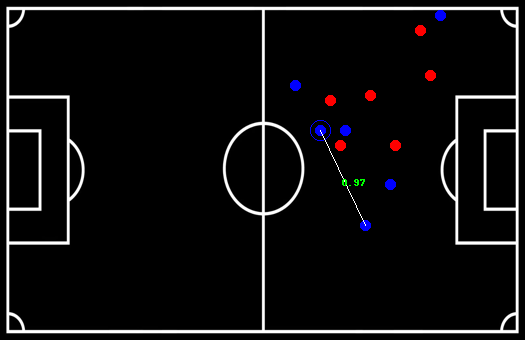

In [177]:
#2D Representation
image_name,image=accuracy(model,val_loader,idx=-1)
image

image_vimp_678.png


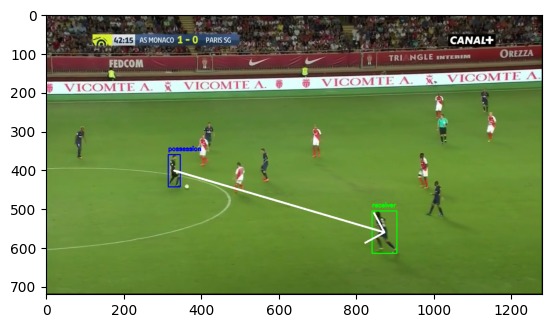

In [190]:
#Original Layover
frame = cv2.imread('downloads/SoccerPass/SoccerPass-COCO/images/val/' + image_name)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame_boxes = bp_df[bp_df['image_name'] == image_name]
bp_boxes = frame_boxes[frame_boxes['bp'] == 1]
br_boxes = frame_boxes[frame_boxes['br'] == 1]

combined_boxes = pd.concat([bp_boxes, br_boxes], ignore_index=True, sort=False)

if not combined_boxes.empty:
    frame = draw_boxes_on_frame(frame, combined_boxes.to_dict('records'))

print(image_name)
_=plt.imshow(frame)
